# Stock Price Prediction using HMM, LSTM, ARIMA, and RNN

In this notebook, we will predict stock prices using various methods including Hidden Markov Model (HMM), Long Short-Term Memory (LSTM), AutoRegressive Integrated Moving Average (ARIMA), and Recurrent Neural Network (RNN). We will compare the performance of these models using various error metrics.


In [1]:
# Import necessary libraries for data manipulation, model building, and evaluation
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


/Users/nikhilkumarpatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load and Prepare Data

In this section, we load the NIFTY 50 data and preprocess it for modeling.


In [2]:
data_csv = pd.read_csv(r"/Users/nikhilkumarpatel/Downloads/NIFTY 50.csv")

data = data_csv[data_csv.columns[0:5]]
data = data[:5348]

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Resample the data to monthly frequency
obs = data.resample('M').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})

# Reset the index to have 'Date' as a column again
obs = obs.reset_index()

# Print the monthly data
print(obs)

data = obs[:162]
print(data)

          Date      Open      High       Low     Close
0   2000-01-31   1482.15   1671.15   1482.15   1546.20
1   2000-02-29   1546.20   1818.15   1521.40   1654.80
2   2000-03-31   1661.50   1773.85   1489.10   1528.45
3   2000-04-30   1528.70   1636.95   1311.30   1406.55
4   2000-05-31   1410.00   1436.60   1201.50   1380.45
..         ...       ...       ...       ...       ...
253 2021-02-28  13758.60  15431.75  13661.75  14529.15
254 2021-03-31  14702.50  15336.30  14264.40  14690.70
255 2021-04-30  14798.40  15044.35  14151.40  14631.10
256 2021-05-31  14481.05  15606.35  14416.25  15582.80
257 2021-06-30  15629.65  15915.65  15450.90  15721.50

[258 rows x 5 columns]
          Date     Open     High      Low    Close
0   2000-01-31  1482.15  1671.15  1482.15  1546.20
1   2000-02-29  1546.20  1818.15  1521.40  1654.80
2   2000-03-31  1661.50  1773.85  1489.10  1528.45
3   2000-04-30  1528.70  1636.95  1311.30  1406.55
4   2000-05-31  1410.00  1436.60  1201.50  1380.45
..        

/var/folders/k5/fy34_4zs2rn2gwm5d84vh2gm0000gn/T/ipykernel_26100/963645270.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs = data.resample('M').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})


## Hidden Markov Model (HMM)

We will implement the HMM to predict future stock prices.

In [9]:
data = data[data.columns[1:5]]
obs = obs[obs.columns[1:5]]
# Calculate number of rows and set training window
T = data.shape[0]
print("T= ", T)

# Define the size of the training window
d = 96
D = 96
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = obs.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(123)

    if(first_time):
      first_time = False
      model = hmm.GaussianHMM(n_components=5)
    else:
      old_model= model
      model = hmm.GaussianHMM(n_components=5, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = obs.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff:  # Threshold for comparison by choosing that new_likelihood which is minimum
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = obs['Close'][T-1] + ((obs['Close'][min_t + 1] - obs['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

# Plot the predicted and observed prices
close = []
truncated_obs = obs.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

# plt.plot(hmm_price,marker='.', label = "HMM Predicted Price")
# plt.plot(close,marker = '.', label= "Observed Price")
# plt.ylabel("Close Price")
# plt.legend()
# plt.show()

T=  162
HMM Prices: 
[5742.0, 5471.8, 5735.3, 6299.15, 6176.1, 6304.0, 6176.1, 5902.05, 5849.7, 6576.3, 6573.35, 7106.900000000001, 7047.500000000001, 7457.8, 7690.85, 7607.4, 8052.000000000001, 8893.8, 8182.500000000001, 8427.5, 8638.35, 8901.85, 8562.900000000001, 8498.8, 8275.55, 8522.400000000001, 8115.05, 8330.3, 7937.900000000001, 8316.650000000001, 7420.1500000000015, 7258.000000000001, 7253.099999999999, 7849.8, 8160.1, 8287.75, 8638.5, 8786.2, 8611.15, 8625.7, 8224.5, 8263.2, 7810.300000000001, 8242.999999999998, 8840.900000000001, 9165.95, 9451.75, 9446.199999999999, 9498.5, 9515.55, 10034.8, 9900.0, 10881.999999999998, 10536.849999999999, 10658.35, 11574.4, 10989.85, 10739.35, 11049.650000000001, 11361.8, 11356.5, 11367.6, 11691.6, 10386.6, 10876.75, 11366.9, 11186.55, 10080.900000000001, 10661.95, 11585.449999999999, 12579.55, 11788.85, 11785.65, 10583.15, 11001.4, 12225.8, 11342.6, 12167.45, 12146.6, 12286.1, 8597.75, 8594.55, 10262.9, 9558.449999999999, 10927.75, 11904.85

## LSTM Model

In this section, we train an LSTM model to predict future stock prices.


In [4]:
# Cell 4: Long Short-Term Memory (LSTM) Model

# Scaling the data to the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(obs['Close'].values.reshape(-1, 1))

# Prepare data for LSTM model (using the first D months)
def prepare_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = obs.shape[0] - D

# Initialize an empty list to store the predictions
lstm_predictions = []

# Initial training on the first 162 months
X_train, y_train = prepare_data(scaled_data, D)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Train the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=5, batch_size=32)

# Iteratively predict the next 96 months and retrain the model
for i in range(96):  # Predict the next 96 months
    X_input = scaled_data[-time_step:]  # Use the last 'time_step' months for prediction
    X_input = X_input.reshape(1, time_step, 1)
    pred = model_lstm.predict(X_input)
    lstm_predictions.append(pred[0, 0])
    
    # Add the predicted data to the training set
    new_data = np.append(scaled_data[:time_step + i + 1], pred)
    scaled_data = np.append(scaled_data, pred).reshape(-1, 1)
    
    # Re-prepare the training data including the new data
    X_train, y_train = prepare_data(scaled_data[:time_step + i + 1], time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    # Retrain the LSTM model with the updated data
    model_lstm.fit(X_train, y_train, epochs=5, batch_size=32)

# Inverse transform the predictions to the original scale
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))

# LSTM predictions for the next 96 months
print(lstm_predictions.shape)


Epoch 1/5


/Users/nikhilkumarpatel/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1524
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0174
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0075
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0127
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step - loss: 0.0072
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0053
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0034
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0018
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.3135e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 5.9505e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.6823e-04
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.1940e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.3445e-04
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━

## ARIMA Model

In this section, we use the ARIMA model to predict future stock prices.


In [5]:
# AutoRegressive Integrated Moving Average (ARIMA) Model

# Use the 'Close' prices for ARIMA model
arima_data = obs['Close']
arima_predictions = []

for i in range(96):
    # Define the ARIMA model (order can be adjusted based on ACF/PACF plots or a grid search)
    model_arima = ARIMA(arima_data[:time_step + i + 1], order=(3, 2, 0))  # Example order, tune as needed
    model_arima_fit = model_arima.fit()

    # Forecast the next 96 months
    arima_prediction = model_arima_fit.forecast(steps=1)
    arima_predictions.append(arima_prediction)


# Convert predictions to a numpy array
arima_predictions = np.array(arima_predictions).reshape(-1, 1)

print(arima_predictions.shape)


(96, 1)


## RNN Model

In this section, we train an RNN model to predict future stock prices.


In [6]:


# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(obs['Close'].values.reshape(-1, 1))

# Prepare data function for RNN model
def prepare_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = obs.shape[0] - D  # D is the training window size

# Initialize an empty list to store the predictions
rnn_predictions = []

# Initial training on the first 162 months
X_train, y_train = prepare_data(scaled_data, time_step)

print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Train the initial RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, epochs=5, batch_size=32)

# Iteratively predict the next month and retrain the model
for i in range(96):  # Predict the next 96 months iteratively
    # Predict the next month
    X_input = scaled_data[-time_step:]  # Use the last 'time_step' months for prediction
    X_input = X_input.reshape(1, time_step, 1)
    pred = model_rnn.predict(X_input)
    rnn_predictions.append(pred[0, 0])
    
    # Add the real data for the next month to the training set
    new_data = np.append(scaled_data[:time_step + i + 1], pred)
    scaled_data = np.append(scaled_data, pred).reshape(-1, 1)
    
    # Re-prepare the training data including the new data
    X_train, y_train = prepare_data(scaled_data[:time_step + i + 1], time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    # Retrain the RNN model with the updated data
    model_rnn.fit(X_train, y_train, epochs=5, batch_size=32)

# Inverse transform the predictions to the original scale
rnn_predictions = scaler.inverse_transform(np.array(rnn_predictions).reshape(-1, 1))

# rnn_predictions now contains the predicted closing prices for the next 96 months
print(rnn_predictions.shape)

(96, 162)
Epoch 1/5


/Users/nikhilkumarpatel/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6611
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2469
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0765
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1206
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - loss: 0.1944
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1798
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1349
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0788
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0040
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0027
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0222
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0470
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - 

## Plot Predictions

Now, we plot the predictions from all models alongside the actual observed prices.


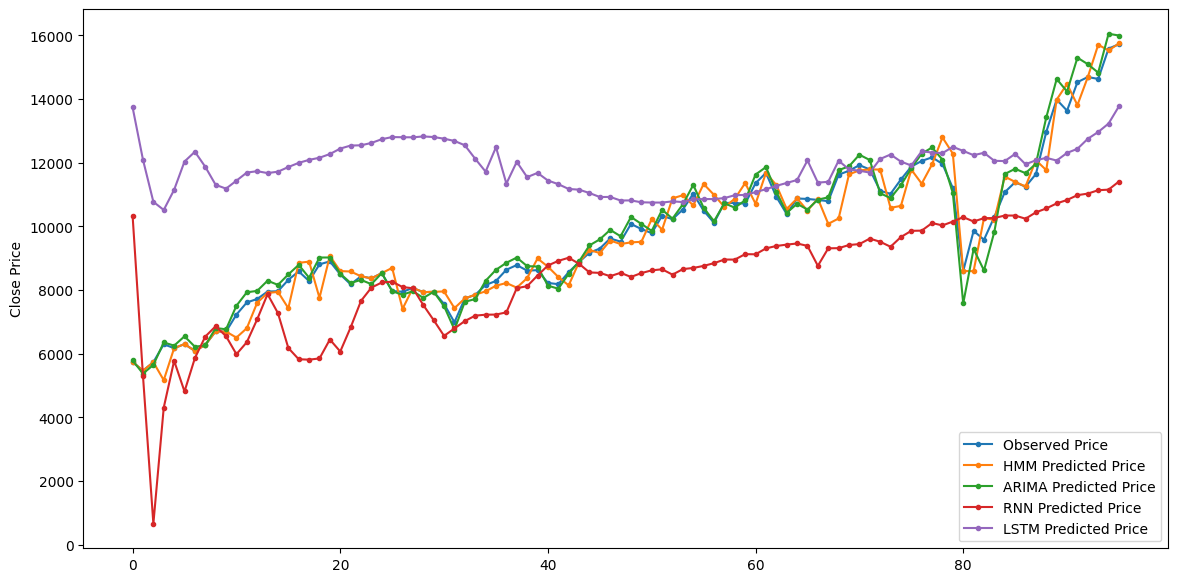

In [7]:
plt.figure(figsize=(14, 7))

# Plot actual prices for the corresponding period
plt.plot(close, marker='.', label='Observed Price')

# Plot HMM predicted prices
plt.plot(hmm_price, marker='.', label='HMM Predicted Price')

# Plot ARIMA predicted prices
plt.plot(arima_predictions, marker='.', label='ARIMA Predicted Price')

# Plot RNN predicted prices
plt.plot(rnn_predictions, marker='.', label='RNN Predicted Price')

# Plot LSTM predicted prices
plt.plot(lstm_predictions, marker='.', label='LSTM Predicted Price')

plt.ylabel("Close Price")
plt.legend()
plt.show()


## Model Comparison and Efficiency Calculation

In this section, we calculate various error metrics for each model and determine the efficiency of HMM compared to LSTM, ARIMA, and RNN.


In [8]:
# Convert lists to numpy arrays
close = np.array(close)
hmm_price = np.array(hmm_price)
lstm_predictions = np.array(lstm_predictions)
arima_predictions = np.array(arima_predictions)
rnn_predictions = np.array(rnn_predictions)

# Ensure all are trimmed to the same length
min_length = min(len(close), len(hmm_price), len(lstm_predictions), len(arima_predictions), len(rnn_predictions))
print(min_length)
close = close[-min_length:]
hmm_price = hmm_price[-min_length:]
lstm_predictions = lstm_predictions[-min_length:]
arima_predictions = arima_predictions[-min_length:]
rnn_predictions = rnn_predictions[-min_length:]

# 1. Absolute Percentage Error (APE)
def ape(real_, pred_):
    return np.mean(np.abs((real_ - pred_) / real_)) * 100

ape_hmm = ape(close, hmm_price)
ape_lstm = ape(close, lstm_predictions)
ape_arima = ape(close, arima_predictions)
ape_rnn = ape(close, rnn_predictions)

# 2. Average Absolute Error (AAE)
def aae(real_, pred_):
    return np.mean(np.abs(real_ - pred_))

aae_hmm = aae(close, hmm_price)
aae_lstm = aae(close, lstm_predictions)
aae_arima = aae(close, arima_predictions)
aae_rnn = aae(close, rnn_predictions)

# 3. Average Relative Percentage Error (ARPE)
def arpe(real_, pred_):
    return np.mean(np.abs((real_ - pred_) / real_)) * 100

arpe_hmm = arpe(close, hmm_price)
arpe_lstm = arpe(close, lstm_predictions)
arpe_arima = arpe(close, arima_predictions)
arpe_rnn = arpe(close, rnn_predictions)

# 4. Root Mean Squared Error (RMSE)
def rmse(real_, pred_):
    return np.sqrt(np.mean((real_ - pred_) ** 2))

rmse_hmm = rmse(close, hmm_price)
rmse_lstm = rmse(close, lstm_predictions)
rmse_arima = rmse(close, arima_predictions)
rmse_rnn = rmse(close, rnn_predictions)

# 5. Cumulative Squared Prediction Error (CSPE)
def cspe(real_, pred_):
    return np.cumsum((real_ - pred_) ** 2)

cspe_hmm = cspe(close, hmm_price)
cspe_lstm = cspe(close, lstm_predictions)
cspe_arima = cspe(close, arima_predictions)
cspe_rnn = cspe(close, rnn_predictions)

# 6. Efficiency Calculation
def efficiency(hmm_metric, other_metric):
    return 1 - (hmm_metric / other_metric)

eff_lstm = {
    'APE': efficiency(ape_hmm, ape_lstm),
    'AAE': efficiency(aae_hmm, aae_lstm),
    'ARPE': efficiency(arpe_hmm, arpe_lstm),
    'RMSE': efficiency(rmse_hmm, rmse_lstm),
    'CSPE': efficiency(np.sum(cspe_hmm), np.sum(cspe_lstm))
}

eff_arima = {
    'APE': efficiency(ape_hmm, ape_arima),
    'AAE': efficiency(aae_hmm, aae_arima),
    'ARPE': efficiency(arpe_hmm, arpe_arima),
    'RMSE': efficiency(rmse_hmm, rmse_arima),
    'CSPE': efficiency(np.sum(cspe_hmm), np.sum(cspe_arima))
}

eff_rnn = {
    'APE': efficiency(ape_hmm, ape_rnn),
    'AAE': efficiency(aae_hmm, aae_rnn),
    'ARPE': efficiency(arpe_hmm, arpe_rnn),
    'RMSE': efficiency(rmse_hmm, rmse_rnn),
    'CSPE': efficiency(np.sum(cspe_hmm), np.sum(cspe_rnn))
}

# Print the results
print("HMM vs LSTM Efficiency:", eff_lstm)
print("HMM vs ARIMA Efficiency:", eff_arima)
print("HMM vs RNN Efficiency:", eff_rnn)


96
HMM vs LSTM Efficiency: {'APE': 0.890937146219806, 'AAE': 0.8692349123404939, 'ARPE': 0.890937146219806, 'RMSE': 0.8423457585905709, 'CSPE': 0.9999977617707737}
HMM vs ARIMA Efficiency: {'APE': 0.8715680554452594, 'AAE': 0.8630819522195345, 'ARPE': 0.8715680554452594, 'RMSE': 0.8447368775568846, 'CSPE': 0.9999975756546479}
HMM vs RNN Efficiency: {'APE': 0.854599116743834, 'AAE': 0.8555084363916333, 'ARPE': 0.854599116743834, 'RMSE': 0.8390495981262363, 'CSPE': 0.999998233714717}
